In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit

# Start a Spark session
spark = SparkSession.builder.appName("WeatherDataProcessing").config("spark.driver.memory", "5g").getOrCreate()


24/02/28 22:54:30 WARN Utils: Your hostname, saramshs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.19 instead (on interface en0)
24/02/28 22:54:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/28 22:54:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/28 22:54:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/02/28 22:54:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


24/02/28 22:54:47 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


====================================================================================================================================================================================
#### Aggregating Weather Data with Apache Spark
##### The code aggregates weather data (humidity, pressure, temperature, wind direction, speed, and conditions) from multiple CSV files for various cities into a single Spark DataFrame. It reads data, renames columns for consistency, joins them on datetime, and adds city attributes (name, country, latitude, longitude), creating a comprehensive dataset for analysis.

In [ ]:
BROAD_WEATHER_COL = 'Broad_Weather_Condition'

# Paths Definition
humidity_path = 'dataset/humidity.csv'
pressure_path = 'dataset/pressure.csv'
temp_path = 'dataset/temperature.csv'
weather_path = 'dataset/weather_description.csv'
wind_dir_path = 'dataset/wind_direction.csv'
wind_spd_path = 'dataset/wind_speed.csv'
city_path = 'dataset/city_attributes.csv'

# Read CSV files into Spark DataFrames
humidity_df = spark.read.csv(humidity_path, header=True, inferSchema=True)
pressure_df = spark.read.csv(pressure_path, header=True, inferSchema=True)
temp_df = spark.read.csv(temp_path, header=True, inferSchema=True)
weather_df = spark.read.csv(weather_path, header=True, inferSchema=True)
wind_dir_df = spark.read.csv(wind_dir_path, header=True, inferSchema=True)
wind_spd_df = spark.read.csv(wind_spd_path, header=True, inferSchema=True)
city_df = spark.read.csv(city_path, header=True, inferSchema=True)

# Define columns
DATETIME_COL = 'datetime'
HUMIDITY_COL = 'humidity'
PRESSURE_COL = 'pressure'
TEMPERATURE_COL = 'temperature'
WIND_DIRECTION_COL = 'wind_direction'
WIND_SPEED_COL = 'wind_speed'
LATITUDE_COL = 'latitude'
LONGITUDE_COL = 'longitude'
CITY_COL = 'city'
COUNTRY_COL = 'country'
WEATHER_CONDITION_COL = 'weather_condition'

def filter_dataframe_by_city_column(dataframe, city_name, new_column_name):
    return dataframe.withColumnRenamed(city_name, new_column_name).select(DATETIME_COL, new_column_name)

def join_dataframes(dataframes, column_name):
    joined_df = dataframes[0]
    for dataframe in dataframes[1:]:
        joined_df = joined_df.join(dataframe, column_name, 'inner')
    return joined_df

weather_measurements_df = None

for row in city_df.collect():    
    city = row['City']
    country = row['Country']
    latitude = row['Latitude']
    longitude = row['Longitude']

    dataframes = [
        filter_dataframe_by_city_column(humidity_df, city, HUMIDITY_COL),
        filter_dataframe_by_city_column(pressure_df, city, PRESSURE_COL),
        filter_dataframe_by_city_column(temp_df, city, TEMPERATURE_COL),
        filter_dataframe_by_city_column(wind_dir_df, city, WIND_DIRECTION_COL),
        filter_dataframe_by_city_column(wind_spd_df, city, WIND_SPEED_COL),
        filter_dataframe_by_city_column(weather_df, city, WEATHER_CONDITION_COL)

    ]

    joined_df = join_dataframes(dataframes, DATETIME_COL) \
        .withColumn(CITY_COL, lit(city)) \
        .withColumn(COUNTRY_COL, lit(country)) \
        .withColumn(LATITUDE_COL, lit(latitude)) \
        .withColumn(LONGITUDE_COL, lit(longitude))

    weather_measurements_df = weather_measurements_df.union(joined_df) if weather_measurements_df else joined_df

# weather_measurements_df.show()



##### Schema of the dataframe

In [3]:
num_rows = weather_measurements_df.count()
num_columns = len(weather_measurements_df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 1640268
Number of columns: 11


In [5]:
weather_measurements_df.printSchema()


root
 |-- datetime: timestamp (nullable = true)
 |-- humidity: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- weather_condition: string (nullable = true)
 |-- city: string (nullable = false)
 |-- country: string (nullable = false)
 |-- latitude: double (nullable = false)
 |-- longitude: double (nullable = false)



#### Removing null data points

In [5]:
for c in weather_measurements_df.columns:
    print(f'Missing values of column `{c}` count: {weather_measurements_df.where(col(c).isNull()).count()}')

Missing values of column `datetime` count: 0


Missing values of column `humidity` count: 28868


Missing values of column `pressure` count: 16680


Missing values of column `temperature` count: 8030


Missing values of column `wind_direction` count: 7975


Missing values of column `wind_speed` count: 7993


Missing values of column `weather_condition` count: 7955
Missing values of column `city` count: 0
Missing values of column `country` count: 0
Missing values of column `latitude` count: 0
Missing values of column `longitude` count: 0


In [2]:
not_null_weather_measurements_df = weather_measurements_df.dropna()


In [4]:
# Not null and consolidated dataframe
not_null_weather_measurements_df.show()

+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|weather_condition|     city|country|latitude|  longitude|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|2012-10-02 09:00:00|    87.0|   807.0| 284.59021694|         268.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 10:00:00|    88.0|   849.0|284.588173552|         281.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 11:00:00|    89.0|   890.0|284.586130164|         295.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 12:00:00|    89.0|   932.0|284.584086776|         309.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 13:00:00|    90.0|   973.0|28

In [7]:
# Specific weather Columns
not_null_weather_measurements_df.groupBy(WEATHER_CONDITION_COL).count().show(truncate=False)


24/02/24 20:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1305.1 KiB


+----------------------------+------+
|weather_condition           |count |
+----------------------------+------+
|fog                         |16247 |
|very heavy rain             |1001  |
|proximity shower rain       |2339  |
|few clouds                  |134584|
|heavy shower snow           |336   |
|light rain                  |127984|
|light intensity drizzle     |8110  |
|light intensity shower rain |3695  |
|broken clouds               |168373|
|overcast clouds             |135049|
|light snow                  |14554 |
|scattered clouds            |144223|
|thunderstorm with heavy rain|396   |
|thunderstorm with light rain|1179  |
|heavy intensity rain        |14075 |
|moderate rain               |43296 |
|light intensity drizzle rain|41    |
|sky is clear                |646304|
|snow                        |3156  |
|light shower snow           |1029  |
+----------------------------+------+
only showing top 20 rows



In [3]:
#weather condition dictionary to map specific data points to broader categories
from typing import Dict, Iterable, List


def get_weather_conditions_aggregation_dict(weather_conditions: Iterable[str]) -> Dict[str, str]:
    
    weather_conditions_dict = dict()
  
    for weather_condition in weather_conditions:
  
        weather_condition_lowered = weather_condition.lower()

        if any(key in weather_condition_lowered for key in ['squall', 'thunderstorm']):
            weather_conditions_dict[weather_condition] = 'thunderstorm'
        elif any(key in weather_condition_lowered for key in ['drizzle', 'rain']):
            weather_conditions_dict[weather_condition] = 'rainy'
        elif any(key in weather_condition_lowered for key in ['sleet', 'snow']):
            weather_conditions_dict[weather_condition] = 'snowy'
        elif 'cloud' in weather_condition_lowered:
            weather_conditions_dict[weather_condition] = 'cloudy'
        elif any(key in weather_condition_lowered for key in ['fog', 'mist', 'haze']):
            weather_conditions_dict[weather_condition] = 'foggy'
        elif any(key in weather_condition_lowered for key in ['clear', 'sun']):
            weather_conditions_dict[weather_condition] = 'sunny'
            
    return weather_conditions_dict

In [4]:
weather_conditions_all = not_null_weather_measurements_df.select(WEATHER_CONDITION_COL).distinct().rdd.flatMap(lambda x: x).collect()
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_all)
broadcast_dict = spark.sparkContext.broadcast(weather_conditions_dict)

24/02/24 23:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1244.5 KiB


In [5]:
# Apply the UDF to the specific weather condition column
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

def map_weather_condition(weather_condition):
    return broadcast_dict.value.get(weather_condition, "Unknown")

map_weather_condition_udf = udf(map_weather_condition, StringType())

# Apply the UDF to the specific weather condition column
weather_measurements_aggregate_df = not_null_weather_measurements_df.withColumn(
    "Broad_Weather_Condition",
    map_weather_condition_udf(col(WEATHER_CONDITION_COL))
)

# Optionally, drop the original specific weather condition column
weather_measurements_aggregate_general_df = weather_measurements_aggregate_df.drop(WEATHER_CONDITION_COL)



In [11]:
# Not null and consolidated dataframe with broad weather conditions
SLOW_OPERATIONS: bool = True
if SLOW_OPERATIONS: weather_measurements_aggregate_general_df.show(5)

24/02/24 20:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1552.5 KiB


+-------------------+--------+--------+-------------+--------------+----------+---------+-------+--------+-----------+-----------------------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|     city|country|latitude|  longitude|Broad_Weather_Condition|
+-------------------+--------+--------+-------------+--------------+----------+---------+-------+--------+-----------+-----------------------+
|2012-10-02 09:00:00|    87.0|   807.0| 284.59021694|         268.0|       0.0|Vancouver| Canada|49.24966|-123.119339|                 cloudy|
|2012-10-02 10:00:00|    88.0|   849.0|284.588173552|         281.0|       0.0|Vancouver| Canada|49.24966|-123.119339|                 cloudy|
|2012-10-02 11:00:00|    89.0|   890.0|284.586130164|         295.0|       0.0|Vancouver| Canada|49.24966|-123.119339|                 cloudy|
|2012-10-02 12:00:00|    89.0|   932.0|284.584086776|         309.0|       0.0|Vancouver| Canada|49.24966|-123.119339|                 cloudy|

In [13]:
# Broad weather condition columns
BROAD_WEATHER_COL = 'Broad_Weather_Condition'
weather_measurements_aggregate_general_df.groupBy(BROAD_WEATHER_COL).count().show(truncate=False)


24/02/24 20:27:09 WARN DAGScheduler: Broadcasting large task binary with size 1418.1 KiB


+-----------------------+------+
|Broad_Weather_Condition|count |
+-----------------------+------+
|rainy                  |203624|
|snowy                  |21500 |
|Unknown                |3333  |
|sunny                  |646304|
|cloudy                 |582229|
|thunderstorm           |10883 |
|foggy                  |139389|
+-----------------------+------+



24/02/24 20:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1028.6 KiB


In [6]:
# Filter out the rows where Broad_Weather_Condition is 'Unknown'

weather_aggregate_filtered_df = weather_measurements_aggregate_general_df.filter(col("Broad_Weather_Condition") != "Unknown")



In [7]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

# Define the window specification
windowSpec = Window.partitionBy("Broad_Weather_Condition").orderBy(col(DATETIME_COL).desc())

# Add row number to each row within the window
weather_ranked_df = weather_aggregate_filtered_df.withColumn("row_number", row_number().over(windowSpec))

# Filter the ranked dataframe to get the latest 10,000 datasets for each BROAD_WEATHER_COL
weather_aggregate_10k_df = weather_ranked_df.filter(col("row_number") <= 10000)

# Drop the row_number column
weather_aggregate_final_df = weather_aggregate_10k_df.drop("row_number")

# Show the final dataframe
weather_aggregate_final_df.groupBy(BROAD_WEATHER_COL).count().show(truncate=False)


#### Statistical distribution of the dataset

In [10]:

weather_aggregate_final_df.describe().show()


24/02/24 21:01:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/02/24 21:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1562.8 KiB
24/02/24 21:02:19 WARN DAGScheduler: Broadcasting large task binary with size 1167.9 KiB


+-------+-----------------+------------------+------------------+------------------+------------------+-----------+-------------+------------------+------------------+-----------------------+
|summary|         humidity|          pressure|       temperature|    wind_direction|        wind_speed|       city|      country|          latitude|         longitude|Broad_Weather_Condition|
+-------+-----------------+------------------+------------------+------------------+------------------+-----------+-------------+------------------+------------------+-----------------------+
|  count|            60000|             60000|             60000|             60000|             60000|      60000|        60000|             60000|             60000|                  60000|
|   mean|71.55261666666667|1016.4122333333333| 286.2820732973409|         184.79965| 3.399583333333333|       NULL|         NULL|38.418978419401576|-88.86701029880867|                   NULL|
| stddev|21.32378976370175|     8.351027

24/02/24 21:02:20 WARN DAGScheduler: Broadcasting large task binary with size 1234.1 KiB


In [9]:
# Save the DataFrame as a single CSV file

# Path where the CSV file will be saved
final_dataset_path = "dataset/final_dataset.csv"


(weather_aggregate_final_df
    .coalesce(1)  # Combine all partitions into one
    .write
    .option("header", "true")  # Include header
    .csv(final_dataset_path))

24/02/24 23:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1562.8 KiB
24/02/24 23:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1333.9 KiB


### Machine Learning Start
============================================================================================

In [6]:
# Split the dataset into train and test sets

train_df, test_df = weather_aggregate_final_df.randomSplit([0.8, 0.2], seed=42)

MAX_TRAIN_SIZE: int = 999_999
# necessary due to DataBricks limits (training on a dataframe larger than this threshold causes an Internal Server Error)
train_df = train_df.limit(MAX_TRAIN_SIZE)


print(f'Train set size:  {train_df.count()} instances')
print(f'Test set size:   {test_df.count()} instances')

### ML pipeline =================================
### Data Encoding Pipeline ==================

In [11]:
# Define the numerical and categorical features
# --------------------------------

NUMERICAL_FEATURES = [HUMIDITY_COL,
                      PRESSURE_COL,
                      TEMPERATURE_COL,
                      WIND_DIRECTION_COL,
                      WIND_SPEED_COL,
                      LATITUDE_COL,
                      LONGITUDE_COL]

CATEGORICAL_FEATURES = []

TARGET_VARIABLE_COL = 'Broad_Weather_Condition'
PREDICTED_TARGET_VARIABLE_COL = f'predicted_{TARGET_VARIABLE_COL}'

LABEL_COL = 'label'
PREDICTION_COL = 'prediction'

FEATURES_COL = 'features'
SCALED_FEATURES_COL = f'scaled_{FEATURES_COL}'

In [12]:
def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:
    
    if append_datetime:
        from datetime import datetime
        path += '-' + datetime.now().strftime("%Y%d%m-%H%M%S")
    
    model.write().overwrite().save(path)

In [20]:
# Save the train and test sets to disk
#===============================================

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql import DataFrame
from pyspark.ml.pipeline import PipelineModel
from typing import List
def encoding_pipeline(dataframe: DataFrame,
                      numerical_features: List[str],
                      categorical_features: List[str],
                      target_variable: str,
                      with_std: bool = True,
                      with_mean: bool = False) -> PipelineModel:
    

    # Indexing, i.e. transform to numerical values, the target column and rename it as the variable `LABEL_COL`
    label_indexer = StringIndexer(inputCol=target_variable, outputCol=LABEL_COL)
    
    # A list of indexers, one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_indexed', handleInvalid='keep') for c in categorical_features]

    # One-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                            outputCols=[f'{indexer.getOutputCol()}_encoded' for indexer in indexers], 
                            handleInvalid='keep')
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    features = encoder.getOutputCols() + numerical_features    
    assembler = VectorAssembler(inputCols=features, outputCol=FEATURES_COL)
    
    # Second feature column with the data scaled accordingly to `withStd` and `withMean`
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol=SCALED_FEATURES_COL, withStd=with_std, withMean=with_mean)

    stages = [label_indexer] + indexers + [encoder] + [assembler] + [scaler]
    pipeline = Pipeline(stages=stages)

    transformer = pipeline.fit(dataframe)

    return transformer

In [4]:
# Train the encoding pipeline with a dataset

data_encoder = encoding_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL)
     
MODELS_PATH: str = 'models'
ENCODING_PIPELINE_PATH: str = f'{MODELS_PATH}data_encoder'

save_pyspark_model(data_encoder, ENCODING_PIPELINE_PATH)


encoded_train_df = data_encoder.transform(train_df)
encoded_test_df = data_encoder.transform(test_df)


encoded_train_df.select([FEATURES_COL, SCALED_FEATURES_COL, LABEL_COL]).show(5)

NameError: name 'encoding_pipeline' is not defined

====================================================================================
## Random Forest Model

In [24]:
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel

rnd_forest_model = RandomForestClassificationModel.load(RANDOM_FOREST_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                   else RandomForestClassifier(featuresCol=FEATURES_COL, labelCol=LABEL_COL).fit(encoded_train_df)
     

rnd_forest_predictions = rnd_forest_model.transform(encoded_test_df)


from pyspark.ml.feature import IndexToString

predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                       outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                       labels=data_encoder.stages[0].labels)


rnd_forest_predictions = predictions_idx_to_str.transform(rnd_forest_predictions)

In [28]:
# Evaluate the predictions of a model

from pyspark.sql import DataFrame
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def eval_predictions(predictions: DataFrame) -> None:
    # Define evaluators for precision, recall, and accuracy
    precision_evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL, predictionCol=PREDICTION_COL, metricName="precisionByLabel")
    recall_evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL, predictionCol=PREDICTION_COL, metricName="recallByLabel")
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL, predictionCol=PREDICTION_COL, metricName="accuracy")

    # Compute metrics
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    accuracy = accuracy_evaluator.evaluate(predictions)
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    # Print metrics
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1_score}')



eval_predictions(rnd_forest_predictions)

In [32]:
# Save the model

RANDOM_FOREST_MODEL_PATH: str = f'{MODELS_PATH}rnd_forest'
# if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    
save_pyspark_model(rnd_forest_model, RANDOM_FOREST_MODEL_PATH)
print("Random Forest model saved")

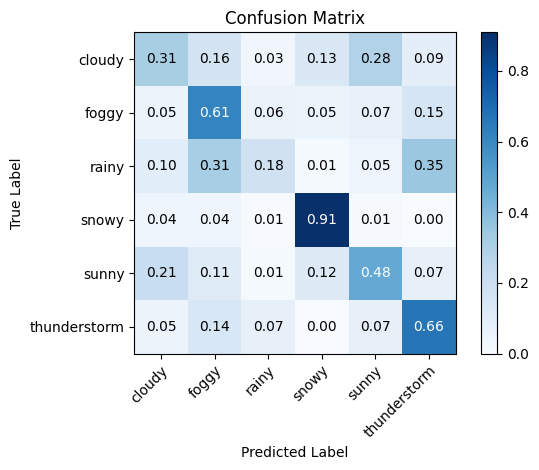

In [36]:
# Plot the confusion matrix

import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(predictions_df: DataFrame,
                          target_col: str,
                          prediction_col: str,
                          normalize: bool = False,
                          title: str = None):
    
    # Compute confusion matrix components
    metrics_data = predictions_df.groupBy(target_col, prediction_col).count().collect()

    # Extract unique labels
    labels = sorted(predictions_df.select(target_col).distinct().rdd.flatMap(lambda x: x).collect())
    pred_labels = sorted(predictions_df.select(prediction_col).distinct().rdd.flatMap(lambda x: x).collect())
    num_labels = max(len(labels), len(pred_labels))

    # Initialize confusion matrix
    cm = np.zeros((num_labels, num_labels), dtype=int)

    # Fill confusion matrix
    label_dict = {label: i for i, label in enumerate(labels)}
    pred_label_dict = {label: i for i, label in enumerate(pred_labels)}
    for row in metrics_data:
        i = label_dict[row[target_col]]
        j = pred_label_dict[row[prediction_col]]
        cm[i, j] = row['count']

    # Normalize if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(num_labels),
           yticks=np.arange(num_labels),
           xticklabels=pred_labels,
           yticklabels=labels,
           title=title if title else 'Confusion Matrix',
           ylabel='True Label',
           xlabel='Predicted Label')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(num_labels):
        for j in range(num_labels):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Usage example
plot_confusion_matrix(rnd_forest_predictions, TARGET_VARIABLE_COL, PREDICTED_TARGET_VARIABLE_COL, normalize= True)


============================================================================================================================================================


============================================================================================================================================================


=====================================================================